In [2]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle

In [3]:
DATA_DIR = '/mnt/chicm/data/open-images/relation'
DETECT_DATA_DIR = '/mnt/chicm/data/open-images/detect'

In [49]:
!ls $DATA_DIR

challenge-2019-attributes-description.csv
challenge-2019-classes-vrd.csv
challenge-2019-relationships-description.csv
challenge-2019-relationship-triplets.csv
challenge-2019-train-vrd-bbox.csv
challenge-2019-train-vrd.csv
challenge-2019-train-vrd-labels.csv
challenge-2019-validation-vrd-bbox.csv
challenge-2019-validation-vrd.csv
challenge-2019-validation-vrd-labels.csv
classes_is_42.csv
top_classes.csv
VRD_sample_submission.csv


In [52]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_test.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...


In [53]:
df_des = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-classes-vrd.csv'), names=['label', 'name'])
df_des.head()

,label,name
0,/m/05r5c,Piano
1,/m/01599,Beer
2,/m/01_5g,Chopsticks
3,/m/01yrx,Cat
4,/m/04_sv,Motorcycle


In [54]:
df_des.name.values

array(['Piano', 'Beer', 'Chopsticks', 'Cat', 'Motorcycle',
       'Tennis racket', 'Football', 'Mobile phone', 'Flute',
       'Tennis ball', 'Chair', 'Woman', 'Boy', 'Coffee table', 'Handbag',
       'Fork', 'Girl', 'Coffee cup', 'Violin', 'Backpack', 'Knife',
       'Snowboard', 'Rugby ball', 'Snake', 'Oven', 'Microwave oven',
       'Man', 'Bench', 'Desk', 'Suitcase', 'Sofa bed', 'Horse',
       'Microphone', 'Table tennis racket', 'Monkey', 'Surfboard',
       'Table', 'Bottle', 'Mug', 'Wine glass', 'Drum', 'Dog', 'Guitar',
       'Ski', 'Bed', 'Spoon', 'Briefcase', 'Hamster', 'Car', 'Bicycle',
       'Camera', 'Dolphin', 'Taxi', 'Van', 'Elephant', 'Racket',
       'Pretzel'], dtype=object)

In [55]:
def get_classes():
    df_classes = pd.read_csv(os.path.join(DATA_DIR, 'classes_is_42.csv'))
    classes = df_classes['classes'].values.tolist()
    stoi = { classes[i]: i for i in range(len(classes)) }
    return classes, stoi

classes, stoi = get_classes()

In [56]:
classes[:2]

['/m/04dr76w,/m/05z87', '/m/04bcr3,/m/083vt']

In [57]:
# visualize

import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


In [58]:
!ls /mnt/chicm/open-images-vrd/work_dirs/is_42_cas  

20190725_123110.log	  20190726_102311.log	    epoch_6.pth
20190725_123232.log	  20190726_102311.log.json  epoch_7.pth
20190725_123429.log	  epoch_1.pth		    latest.pth
20190725_123429.log.json  epoch_2.pth		    preds_0726_2.pkl
20190726_043206.log	  epoch_3.pth		    preds_0726.pkl
20190726_043337.log	  epoch_4.pth
20190726_043337.log.json  epoch_5.pth


In [59]:
# submission

with open('/mnt/chicm/open-images-vrd/work_dirs/is_42_cas/preds_0726_2.pkl', 'rb') as f:
    preds = pickle.load(f)


In [60]:
len(preds[0])

42

In [61]:
preds[0]

[array([], shape=(0, 5), dtype=float32),
 array([[3.20278144e+00, 4.86066925e+02, 4.73416626e+02, 6.75949829e+02,
         3.80674094e-01],
        [3.75406219e+02, 4.93972656e+02, 4.71271759e+02, 6.05588074e+02,
         1.40363008e-01],
        [3.75828430e+02, 5.15347534e+02, 4.73022308e+02, 5.61612000e+02,
         4.79853712e-02],
        [0.00000000e+00, 4.79386749e+02, 9.62174377e+01, 6.08989441e+02,
         2.43334398e-02],
        [7.33396484e+02, 2.76986633e+02, 8.02493958e+02, 3.15353363e+02,
         2.26631630e-02],
        [3.73434601e+02, 4.96855469e+02, 5.14712219e+02, 5.60166077e+02,
         2.02567577e-02],
        [0.00000000e+00, 3.50905396e+02, 9.35907410e+02, 6.80667969e+02,
         1.33302556e-02],
        [3.74670868e+02, 4.44539825e+02, 5.13992126e+02, 6.26998108e+02,
         1.28920805e-02],
        [3.86811310e+02, 5.43776489e+02, 4.64288940e+02, 6.03853516e+02,
         1.13468925e-02],
        [3.56859650e+02, 4.93837860e+02, 4.78989136e+02, 6.73445251e

In [63]:
classes[:5]

['/m/04dr76w,/m/05z87',
 '/m/04bcr3,/m/083vt',
 '/m/04bcr3,/m/05z87',
 '/m/01_5g,/m/083vt',
 '/m/01940j,/m/0dnr7']

In [64]:
#th = 0.1
def get_preds(raw_pred):
    res = {
        'labels': [],
        'scores': [],
        'bboxes': []
    }
    for i, p in enumerate(raw_pred):
        if len(p) > 0:
            for e in p:
                #th = get_threshold(classes[i])
                if True:
                #if e[4] > th:
                    res['labels'].append(i)
                    res['scores'].append(e[4])
                    res['bboxes'].append(e[:4])
    res['labels'] = np.array(res['labels'])
    res['scores'] = np.array(res['scores'])
    res['bboxes'] = np.array(res['bboxes'])
    return res

In [65]:
#print(get_preds(preds[0]))
#tmp = get_preds(preds[0])['labels']
#print(get_preds(preds[0])['scores'])
#print(tmp)
#tmp = [classes[i] for i in tmp]
#print(tmp)
#tmp = [df_des.loc[df_des.label==x].name.values.tolist()[0] for x in tmp]
#print(tmp)

In [66]:
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'
def show_preds(idx):
    plt.figure(figsize=(15, 10))
    p = get_preds(preds[idx])
    img_id = df_test.iloc[idx].ImageId
    fn = os.path.join(TEST_IMG_DIR, '{}.jpg'.format(img_id))
    img = Image.open(fn)
    draw_bounding_boxes_on_image(img, p['bboxes'])
    
    plt.imshow(img)
    labels = [classes[i].split(',')[0] for i in p['labels']]
    labels = [df_des.loc[df_des.label==x].name.values[0] for x in labels]
    #print(labels)
    print(list(zip(labels, p['scores'])))

[('Table', 0.3806741), ('Table', 0.14036301), ('Table', 0.04798537), ('Table', 0.02433344), ('Table', 0.022663163), ('Table', 0.020256758), ('Table', 0.013330256), ('Table', 0.0128920805), ('Table', 0.011346892), ('Table', 0.008500521), ('Table', 0.00813341), ('Table', 0.0073871952), ('Table', 0.006771671), ('Table', 0.04438815), ('Table', 0.009530337), ('Piano', 0.009823551), ('Piano', 0.00850315), ('Sofa bed', 0.033717785), ('Sofa bed', 0.0065456107), ('Desk', 0.2209585), ('Desk', 0.00938471), ('Chair', 0.042999156), ('Chair', 0.03517701), ('Chair', 0.03173435), ('Chair', 0.021482015), ('Chair', 0.013551152), ('Chair', 0.007537435), ('Chair', 0.0065911436), ('Chair', 0.029194023), ('Chair', 0.025636328), ('Chair', 0.024674837), ('Chair', 0.016626067), ('Chair', 0.009124132), ('Chair', 0.0074824677), ('Chair', 0.0064884825), ('Sofa bed', 0.069588654), ('Sofa bed', 0.013736935), ('Sofa bed', 0.011234535), ('Chair', 0.50029016), ('Chair', 0.43017587), ('Chair', 0.3163828), ('Chair', 0.1

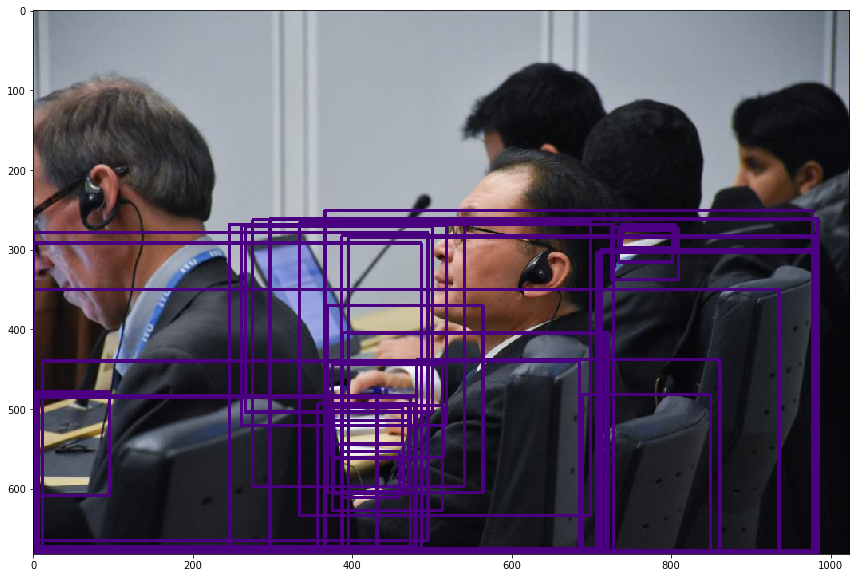

In [72]:
show_preds(0)

In [73]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


In [74]:
df_test['h'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[1])

In [75]:
df_test['w'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[0])

In [76]:
df_test.head()

,ImageId,PredictionString,h,w
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,681,1024
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,768,1024
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024


In [77]:
final_preds = []

for p in tqdm(preds, total=len(preds)):
    final_preds.append(get_preds(p))

100%|██████████| 99999/99999 [00:11<00:00, 9027.78it/s] 


In [78]:
total_objs = 0
for p in final_preds:
    total_objs += len(p['labels'])
print(total_objs)

4699259


In [79]:
def get_pred_str(pred, w, h):
    res = []
    for label, score, bbox in zip(pred['labels'], pred['scores'], pred['bboxes']):
        #res.append(classes[label])
        label1, label2 = classes[label].split(',')
        
        res.append('{:.7f}'.format(score))
        res.append(label1)
        res.append('{:.7f}'.format(bbox[0]/w))
        res.append('{:.7f}'.format(bbox[1]/h))
        res.append('{:.7f}'.format(bbox[2]/w))
        res.append('{:.7f}'.format(bbox[3]/h))

        res.append(label2)
        res.append('{:.7f}'.format(bbox[0]/w))
        res.append('{:.7f}'.format(bbox[1]/h))
        res.append('{:.7f}'.format(bbox[2]/w))
        res.append('{:.7f}'.format(bbox[3]/h))
        res.append('is')
        
    res = [str(x) for x in res]
    return ' '.join(res)

In [80]:
pred_strs = []
for i, p in tqdm(enumerate(final_preds), total=len(final_preds)):
    h = df_test.iloc[i].h
    w = df_test.iloc[i].w
    pred_strs.append(get_pred_str(p, w, h))
    

100%|██████████| 99999/99999 [03:13<00:00, 516.75it/s]


In [81]:
pred_strs[:5]

['0.3806741 /m/04bcr3 0.0031277 0.7127081 0.4623209 0.9911288 /m/083vt 0.0031277 0.7127081 0.4623209 0.9911288 is 0.1403630 /m/04bcr3 0.3666076 0.7243001 0.4602263 0.8879591 /m/083vt 0.3666076 0.7243001 0.4602263 0.8879591 is 0.0479854 /m/04bcr3 0.3670200 0.7556415 0.4619358 0.8234780 /m/083vt 0.3670200 0.7556415 0.4619358 0.8234780 is 0.0243334 /m/04bcr3 0.0000000 0.7029131 0.0939623 0.8929464 /m/083vt 0.0000000 0.7029131 0.0939623 0.8929464 is 0.0226632 /m/04bcr3 0.7162075 0.4061388 0.7836855 0.4623950 /m/083vt 0.7162075 0.4061388 0.7836855 0.4623950 is 0.0202568 /m/04bcr3 0.3646822 0.7285271 0.5026487 0.8213579 /m/083vt 0.3646822 0.7285271 0.5026487 0.8213579 is 0.0133303 /m/04bcr3 0.0000000 0.5145240 0.9139721 0.9980469 /m/083vt 0.0000000 0.5145240 0.9139721 0.9980469 is 0.0128921 /m/04bcr3 0.3658895 0.6518179 0.5019454 0.9193521 /m/083vt 0.3658895 0.6518179 0.5019454 0.9193521 is 0.0113469 /m/04bcr3 0.3777454 0.7973262 0.4534072 0.8854157 /m/083vt 0.3777454 0.7973262 0.4534072 0.8

In [82]:
len(pred_strs)

99999

In [83]:
df_test.PredictionString = pred_strs
df_test.head()

,ImageId,PredictionString,h,w
0,21135d5ed0e7a0b7,0.3806741 /m/04bcr3 0.0031277 0.7127081 0.4623...,682,1024
1,763c72626bf24534,0.7894505 /m/04bcr3 0.6918395 0.8270421 0.9988...,681,1024
2,7540c162180973b1,0.0402823 /m/04bcr3 0.3689175 0.6536201 0.6134...,682,1024
3,c4e522dce52cb02f,0.7901130 /m/04bcr3 0.8337175 0.6788673 0.9917...,768,1024
4,cafcd9496c808085,0.1362440 /m/04dr76w 0.0390787 0.0196190 0.961...,682,1024


In [84]:
df_test.to_csv('sub_is_42_0726_2.csv', index=False, columns=['ImageId', 'PredictionString'])

In [85]:
!kaggle competitions submit -c open-images-2019-visual-relationship -f sub_is_42_0726_2.csv -m "submit"

100%|████████████████████████████████████████| 504M/504M [00:22<00:00, 23.8MB/s]
Successfully submitted to Open Images 2019 - Visual Relationship

In [46]:
!head -n 2 sub_is_42_0726_1.csv

ImageId,PredictionString
21135d5ed0e7a0b7,0.4072160 /m/04bcr3 0.0039612 0.7192280 0.4546969 0.9895010 /m/083vt 0.0039612 0.7192280 0.4546969 0.9895010 is 0.0712087 /m/04bcr3 0.3696319 0.7295010 0.4566138 0.8919654 /m/083vt 0.3696319 0.7295010 0.4566138 0.8919654 is 0.0568501 /m/04bcr3 0.0000000 0.7063426 0.0939232 0.9980444 /m/083vt 0.0000000 0.7063426 0.0939232 0.9980444 is 0.0364757 /m/04bcr3 0.3685612 0.7174960 0.4866330 0.9846825 /m/083vt 0.3685612 0.7174960 0.4866330 0.9846825 is 0.0349968 /m/04bcr3 0.0219411 0.6207415 0.7121553 0.9980469 /m/083vt 0.0219411 0.6207415 0.7121553 0.9980469 is 0.0285137 /m/04bcr3 0.3697023 0.7602207 0.4578472 0.8248381 /m/083vt 0.3697023 0.7602207 0.4578472 0.8248381 is 0.0189172 /m/04bcr3 0.3788468 0.6519151 0.7564875 0.9977310 /m/083vt 0.3788468 0.6519151 0.7564875 0.9977310 is 0.0183419 /m/04bcr3 0.0009914 0.7448131 0.0888157 0.8844225 /m/083vt 0.0009914 0.7448131 0.0888157 0.8844225 is 0.0165919 /m/04bcr3 0.3662596 0.7334173 0.5000860 0.8336586 /m